### We have done the EDA extensively. 
### Now let's do the feature selection, some feature engineering and modeling.

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib_inline.backend_inline as plt_inline
plt_inline.set_matplotlib_formats('svg')

In [115]:
# Display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [116]:
train_df = pd.read_csv('dataset/train.csv')
test_df = pd.read_csv('dataset/test.csv')

In [117]:
y = np.log(train_df['SalePrice']) # Fixing the skewness with log transform
X = pd.concat([train_df.drop(['SalePrice'], axis=1), test_df])
X.set_index('Id', inplace=True)

## Fixing Missing Value

**As we already saw 'PoolQC', 'Alley', 'Fence', 'MiscFeature' have more than 70% null values**  
**and have no meaningful correlation with Sale Price, we'll drop them.**

In [118]:
X.drop(['PoolQC', 'Alley', 'Fence', 'MiscFeature'], axis=1, inplace=True)

Now, out of total 34 features that have missing values we are left with 30. I will divide them into three groups based on the data description:
   - **Group 1 - Categorical variables where `NA` means no feature:** `FireplaceQu`, `GarageType`, `GarageFinish`, `GarageQual`, `GarageCond`, `BsmtQual`, `BsmtCond`, `BsmtExposure`, `BsmtFinType1`, `BsmtFinType2`, `MasVnrType` (15 variables)
   
      For this group I will impute `null` with `'NA'`.
   
   - **Group 2 - Numerical variables where `NA` means no feature:** `GarageArea`, `GarageCars`, `BsmtFinSF1`, `BsmtFinSF2`, `BsmtUnfSF`, `TotalBsmtSF`, `BsmtFullBath`, `BsmtHalfBath`, `MasVnrArea` (10 variables)
   
      For this group I will impute `null` with `0`.
    
   - **Group 3 - Other variables:** `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities`, `LotFrontage`, `GarageYrBlt` (9 variables)
        - I will impute `Functional`, `MSZoning`, `Electrical`, `KitchenQual`, `Exterior1st`, `Exterior2nd`, `SaleType`, `Utilities` with their *modes*,
        - impute `LotFrontage` with its *mean*,
        - impute `GarageYrBlt` with `YearBuilt`.

In [119]:
group1 = ['FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType']

group2 = ['GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

group3 = [ 'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities']


X[group1] = X[group1].fillna('NA')
X[group2] = X[group2].fillna(0)
X[group3] = X[group3].fillna(X[group3].mode().iloc[0])
X['LotFrontage'] = X['LotFrontage'].fillna(X['LotFrontage'].mean())
X['GarageYrBlt'] = X['GarageYrBlt'].fillna(X['YearBuilt'])

In [120]:
print(sum(X.isnull().sum())) 
X.shape

0


(2919, 75)

As we have observed in the eda section, there are two observations lying separately from the rest. They have large living area but low price. They are the outliers that we are looking for. I will delete them from the training set.

In [121]:
outlier_index = train_df[(train_df.GrLivArea > 4000)
                        & (train_df.SalePrice < 200000)].index
X.drop(outlier_index, axis=0, inplace=True)
y.drop(outlier_index, axis=0, inplace=True)

## Feature Engineering
In this section, we create several new features from the existing dataset to enhance our model's ability to capture important characteristics of the houses. These features include:

- totalSqft: The combined total square footage of the basement, first floor, and second floor.
- totalBath: An aggregate measure of the total number of bathrooms, considering both full and half bathrooms, including basement bathrooms.
- houseAge: The age of the house at the time of sale.
- isRemodeled: A binary indicator for whether the house was remodeled.
- isNew: A binary indicator for whether the house is newly built.

In [122]:
X['totalSqft'] = X['TotalBsmtSF'] + X['1stFlrSF'] + X['2ndFlrSF']
X['totalBath'] = X['FullBath'] + X['BsmtFullBath'] + 0.5 * (X['HalfBath'] + X['BsmtHalfBath'])
X['houseAge'] = (X['YrSold'] - X['YearBuilt']).clip(lower=0)
X['isRemodeled'] = np.where(X['YearRemodAdd'] == X['YearBuilt'], 0, 1)
X['isNew'] = np.where(X['YrSold'] == X['YearBuilt'], 1, 0)

In [123]:
to_factor_cols = ['YrSold', 'MoSold', 'MSSubClass']

for col in to_factor_cols:
    X[col] = X[col].apply(str)

### Label Encoding the columns with ordinal sense

In [124]:
categorical_mappings = {
    'GarageCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'GarageFinish': {'NA': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3},
    'FireplaceQu': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'Functional': {'Sal': 0, 'Sev': 1, 'Maj2': 2, 'Maj1': 3, 'Mod': 4, 'Min2': 5, 'Min1': 6, 'Typ': 7},
    'KitchenQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'HeatingQC': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'BsmtFinType2': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtFinType1': {'NA': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6},
    'BsmtExposure': {'NA': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4},
    'BsmtQual': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'BsmtCond': {'NA': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},
    'ExterCond': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'ExterQual': {'Po': 0, 'Fa': 1, 'TA': 2, 'Gd': 3, 'Ex': 4},
    'LandSlope': {'Sev': 0, 'Mod': 1, 'Gtl': 2},
    'LotShape': {'IR3': 0, 'IR2': 1, 'IR1': 2, 'Reg': 3}
}

for name, labels in categorical_mappings.items():
    if name in X.columns:
        X[name] = X[name].map(labels)

### Fixing Skewness

In [125]:
# Filter for numerical columns
numerical_cols = X.select_dtypes(include=['number'])

# Calculate skewness
skewness = numerical_cols.skew().sort_values(ascending=False)

# Filter skewness values to include only those with an absolute value greater than 0.75
significant_skewness = skewness[abs(skewness) > 0.75]

print(significant_skewness)

MiscVal          21.950962
PoolArea         16.901170
LotArea          12.830707
LowQualFinSF     12.090757
3SsnPorch        11.377932
isNew             4.712834
KitchenAbvGr      4.302763
BsmtFinSF2        4.146636
EnclosedPorch     4.004778
ScreenPorch       3.947131
BsmtHalfBath      3.932018
BsmtFinType2      3.152573
MasVnrArea        2.613857
OpenPorchSF       2.535314
WoodDeckSF        1.842544
LotFrontage       1.647847
totalSqft         1.512282
1stFlrSF          1.469401
BsmtFinSF1        1.425660
ExterCond         1.317471
GrLivArea         1.269770
TotalBsmtSF       1.157104
BsmtExposure      1.117945
BsmtUnfSF         0.919774
2ndFlrSF          0.862336
ExterQual         0.785707
TotRmsAbvGrd      0.758543
LotShape         -1.261181
BsmtQual         -1.269123
GarageQual       -3.263939
GarageCond       -3.383413
BsmtCond         -3.604515
Functional       -4.964228
LandSlope        -4.975813
dtype: float64


In [126]:
# List of skewed columns
skewed_cols = list(skewness[abs(skewness) > 0.5].index)

# Remove 'MSSubClass' and 'SalePrice'
skewed_cols = [
    col for col in skewed_cols if col not in ['MSSubClass', 'SalePrice']
]

# Log-transform skewed columns
for col in skewed_cols:
    X[col] = np.log1p(X[col])

## Feature Scaling

In [127]:
from sklearn.preprocessing import RobustScaler
numerical_cols = list(X.select_dtypes(exclude=['object']).columns)
scaler = RobustScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

## Encoding Categorical Columns with no ordinal sense with One Hot Encoding

In [128]:
# All categorical columns which categories have no ordinal sense
cat_cols = list(X.select_dtypes(include='object').columns)

for column in cat_cols:
    if column in X.columns:
        one_hot = pd.get_dummies(X[column], prefix=column, dtype=int)
        X = pd.concat([X.drop(column, axis=1), one_hot], axis=1)

**Let's ensure there are no non numerical values in the final dataframe.**

In [129]:
print(cat_cols)

['MSSubClass', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'CentralAir', 'Electrical', 'GarageType', 'PavedDrive', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition']


In [130]:
train_df = X.iloc[:len(y), :]
test_df = X.iloc[len(y):, :]
print("TrainSet shape:", train_df.shape)
print("TestSet shape:", test_df.shape)

TrainSet shape: (1458, 253)
TestSet shape: (1459, 253)


## Training and Modeling

In [131]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from catboost import CatBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, mean_squared_log_error

In [132]:
X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.3, random_state=247)

In [175]:
# Initialize models
models = {
    'Random Forest Regressor': RandomForestRegressor(n_estimators=500),
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500, max_depth=2),
    'XGBoost Regressor': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, min_child_weight=1, 
                                        gamma=0, subsample=0.8, colsample_bytree=0.8),
    'LGBM Regressor': LGBMRegressor(n_estimators=500, learning_rate=0.1, max_depth=2, verbosity=-1),

    'Support Vector Regressor': SVR(kernel='rbf', C=100, epsilon=0.1),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'ElasticNet Regression': ElasticNet(alpha=1.0, l1_ratio=0.5),
    'CatBoost Regressor': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0),
    'MLP Regressor': MLPRegressor(hidden_layer_sizes=(100, 100), max_iter=500),
    'K-Nearest Neighbors Regressor': KNeighborsRegressor(n_neighbors=5)
}

def calculateRMSLE(model, X, y, test_size=0.3, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Calculate RMSLE
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return rmsle, rmse

# Train and evaluate models
for name, model in models.items():
    rmsle, rmse = calculateRMSLE(model, X_train, y_train)
    print(f'RMSLE: {rmsle:.8f} | RMSE: {rmse} - {name}')

RMSLE: 0.01094560 | RMSE: 0.14025354317099809 - Random Forest Regressor
RMSLE: 0.00981272 | RMSE: 0.12663632674567385 - Gradient Boosting Regressor
RMSLE: 0.00990989 | RMSE: 0.1275084198887085 - XGBoost Regressor
RMSLE: 0.01028893 | RMSE: 0.13249896407485512 - LGBM Regressor
RMSLE: 0.01209916 | RMSE: 0.15585010237424393 - Support Vector Regressor
RMSLE: 0.00990463 | RMSE: 0.1276110903414153 - Ridge Regression
RMSLE: 0.00898091 | RMSE: 0.11598606871969096 - Lasso Regression
RMSLE: 0.03041963 | RMSE: 0.39528360572662485 - ElasticNet Regression
RMSLE: 0.00969222 | RMSE: 0.12541389899623495 - CatBoost Regressor
RMSLE: 0.02520630 | RMSE: 0.32375866340808934 - MLP Regressor
RMSLE: 0.01542965 | RMSE: 0.19936978847011905 - K-Nearest Neighbors Regressor


## We will pick top 5 and do the cross validation.

In [65]:
from sklearn.model_selection import KFold, cross_val_score

def getCrossValRMSLE(model, X, y, n_splits=4, random_state=42):
    kf = KFold(n_splits, shuffle=True, random_state=random_state)
    rmse = np.sqrt(-cross_val_score(
        model, X, y, scoring="neg_mean_squared_error", cv=kf))
    rmsle = np.sqrt(-cross_val_score(
        model, X, y, scoring="neg_mean_squared_log_error", cv=kf))
    return rmsle.mean(), rmse.mean()

In [176]:
# Initialize models
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(n_estimators=500, max_depth=2),
    'XGBoost Regressor': XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, min_child_weight=1, 
                                        gamma=0, subsample=0.8, colsample_bytree=0.8),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'CatBoost Regressor': CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1, verbose=0)
}

for name, model in models.items():
    rmsle, rmse = getCrossValRMSLE(model, X_train, y_train, n_splits=4)
    print(f'{name} RMSLE: {rmsle:.8f} | RMSE: {rmse}')

Gradient Boosting Regressor RMSLE: 0.01019350 | RMSE: 0.1300984523503288
XGBoost Regressor RMSLE: 0.01056239 | RMSE: 0.13656537480137648
Ridge Regression RMSLE: 0.01040945 | RMSE: 0.13588840911443892
Lasso Regression RMSLE: 0.01006607 | RMSE: 0.1311888861781953
CatBoost Regressor RMSLE: 0.00979303 | RMSE: 0.1264587607231797


## Hyperparameter Tuning

In [112]:
from sklearn.model_selection import GridSearchCV

In [195]:
def plot_cv_results(grid_search, param_name, title='Model Performance vs Parameter'):
    """
    Plot cross-validation results for a GridSearchCV object.
    
    Parameters:
    - grid_search: GridSearchCV object
    - param_name: str, name of the parameter to plot
    - title: str, title of the plot
    """
    # Extracting the results
    mean_scores = grid_search.cv_results_['mean_test_score']
    params = grid_search.cv_results_[f'param_{param_name}'].data
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(params, mean_scores, marker='o')
    plt.xlabel(param_name.capitalize())
    plt.ylabel('Error')
    plt.title(title)
    plt.grid(True)
    plt.show()

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 4, 5, 6],
    'learning_rate': [0.01, 0.1, 0.2]
}

gbr = GradientBoostingRegressor()
gbr_grid = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error')
gbr_grid.fit(X_train, y_train)
print("Best parameters for GBR:", gbr_grid.best_params_)
#Best parameters for GBR: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}

In [ ]:
param_grid = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.7, 0.8, 0.9]
}

xgb = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')
xgb_grid = GridSearchCV(estimator=xgb, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgb_grid.best_params_)
#Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1500, 'subsample': 0.7}

Best parameters for Ridge Regression: {'alpha': 24.757575757575758}


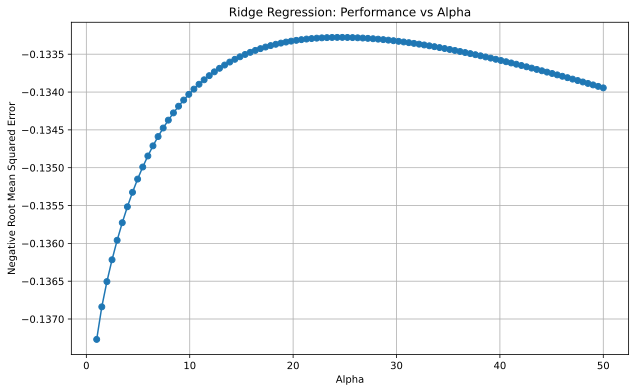

In [194]:
param_grid = {
    'alpha': np.linspace(1, 50, 100).tolist()
}

ridge = Ridge()
ridge_grid = GridSearchCV(estimator=ridge, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error')
ridge_grid.fit(X_train, y_train)
print("Best parameters for Ridge Regression:", ridge_grid.best_params_)
#Best parameters for Ridge Regression: {'alpha': 24.48}

# Visualize the results
plot_cv_results(ridge_grid, 'alpha', 'Ridge Regression: Performance vs Alpha')

Best parameters for Lasso Regression: {'alpha': 0.0005703517587939698}


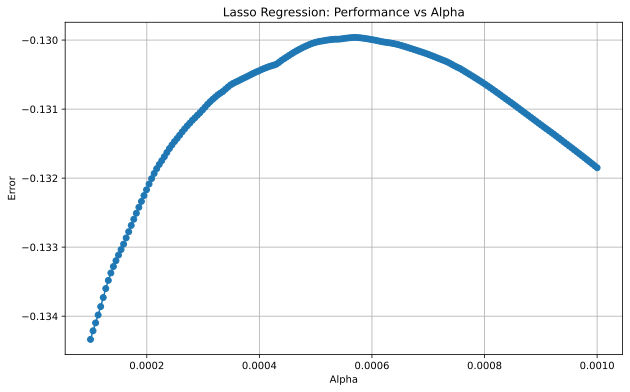

In [197]:
param_grid = {
    'alpha': np.linspace(0.0001, 0.001, 200).tolist() 
}

lasso = Lasso(max_iter=10000)
lasso_grid = GridSearchCV(estimator=lasso, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error')
lasso_grid.fit(X_train, y_train)
print("Best parameters for Lasso Regression:", lasso_grid.best_params_)
#Best parameters for Lasso Regression: {'alpha': 0.0005700000000000001}

# Visualize the results
plot_cv_results(lasso_grid, 'alpha', 'Lasso Regression: Performance vs Alpha')

In [ ]:
param_grid = {
    'iterations': [200, 500, 1000],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'l2_leaf_reg': [1, 3, 5, 10],
    'subsample': [0.7, 0.8, 0.9]
}
catboost = CatBoostRegressor(loss_function='RMSE', verbose=0)
catboost_grid = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=4, scoring='neg_root_mean_squared_error')

catboost_grid.fit(X_train, y_train)
print("Best parameters for CatBoost:", catboost_grid.best_params_)
print("Best RMSE score:", -catboost_grid.best_score_)
# Best parameters for CatBoost: {'depth': 4, 'iterations': 1000, 'l2_leaf_reg': 5, 'learning_rate': 0.05, 'subsample': 0.9}
# Best RMSE score: 0.12619692530072585

In [177]:
models = {
    'Gradient Boosting Regressor': GradientBoostingRegressor(
        learning_rate=0.1,
        max_depth=3,
        n_estimators=300
    ),
    'XGBoost Regressor': XGBRegressor(
        learning_rate=0.01,
        max_depth=3,
        n_estimators=1500,
        subsample=0.7,
        objective='reg:squarederror',
        eval_metric='rmse'
    ),
    'Ridge Regression': Ridge(alpha=24.48),
    'Lasso Regression': Lasso(alpha=0.00057),
    'CatBoost Regressor': CatBoostRegressor(
        depth=4,
        iterations=1000,
        l2_leaf_reg=5,
        learning_rate=0.05,
        subsample=0.9,
        loss_function='RMSE',
        verbose=0
    )
}

# Evaluate models with best parameters
for name, model in models.items():
    rmsle, rmse = getCrossValRMSLE(model, X_train, y_train, n_splits=4)
    print(f'{name} RMSLE: {rmsle:.8f} | RMSE: {rmse}')

Gradient Boosting Regressor RMSLE: 0.01007523 | RMSE: 0.13078958412806607
XGBoost Regressor RMSLE: 0.01012993 | RMSE: 0.1314283562356352
Ridge Regression RMSLE: 0.01024415 | RMSE: 0.13370682122657623
Lasso Regression RMSLE: 0.00997563 | RMSE: 0.1299247006582078
CatBoost Regressor RMSLE: 0.00981467 | RMSE: 0.12688766593849116


#### Voting

In [181]:
# Convert models dictionary to list of tuples
model_tuples = [(name, model) for name, model in models.items()]

# Create the Voting Regressor with the models
voting_regressor = VotingRegressor(estimators=model_tuples)

rmsle, rmse = calculateRMSLE(voting_regressor, X_train, y_train)
print("Voting Regressor (Ensemble Model):")
print(f"RMSLE: {rmsle:.5f} | RMSE: {rmse:.5f}")

Voting Regressor (Ensemble Model):
RMSLE: 0.00882 | RMSE: 0.11370


#### Stacking 

In [179]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression  

# Convert models dictionary to list of tuples
model_tuples = [(name, model) for name, model in models.items()]
stacking_regressor = StackingRegressor(estimators=model_tuples, final_estimator=LinearRegression())

# Calculate RMSLE and RMSE for the stacking model
rmsle, rmse = calculateRMSLE(stacking_regressor, X_train, y_train)

print("Stacking Regressor (Ensemble Model):")
print(f"RMSLE: {rmsle:.5f} | RMSE: {rmse:.5f}")

Stacking Regressor (Ensemble Model):
RMSLE: 0.00889 | RMSE: 0.11464


#### We can observe voting model is performing better. So, we'll choose it as our final model.

In [182]:
final_model_voting = voting_regressor.fit(train_df, y)

In [184]:
y_pred = final_model_voting.predict(test_df)
final_predictions = np.exp(y_pred)
output = pd.DataFrame({'Id': test_df.index, 'SalePrice': final_predictions})
output.to_csv('submission.csv', index=False)